In [111]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:100% !important;}</style>"))

In [112]:
# section1 で実装したものをインポート
from maze import MazeEnv, a2m
from agents import Agent
from policies import Policy, Random

# 2. 価値推定に基づく学習アルゴリズム
---
## 2-1. 行動価値関数 $Q(s,a)$ と貪欲な方策
方策として前節の**`Random`**でもゲームのプレイは出来ましたが、当然ムダな動きが多いので、
* 各状態 s に対して「最適」な行動 a が存在するか？

というのは自然な問いでしょう。素朴には「得られる即時報酬の総和」$\sum_t r_t$ を最大化すれば良い気がしますが、よく取られるのは適当な減衰率 0<γ<1 を導入した、時刻t からの減衰和です：

$$
g_t = \sum_{k=0}^\infty \gamma^k r_{t+1+k}
$$

これを**収益(return)**といいます。

この値を MDP の系列の各時刻で最大にするようにしたいわけですが、$g_t, r_t$は確率変数なので、このままではゲームのプレイサンプル毎に値が変動してしまいます。

### ● 行動価値関数 $Q(s,a)$
そこでこれを、$P_s, P_r, \pi$の確率から成る MDP における期待値で表すことにします。

$$
Q(s, a) = \langle g_t \rangle_{(s_t, a_t)=(s,a)}
$$

これを**行動価値関数(action value function)**と言います。
MDPと並列して図示すると、

$$
\left. \begin{array}{l:r:ll:ll:l|l}
\dots
&
s, a
{\to} 
&
s_{t+1}
&
\overset{\pi(\cdot|s_{t+1})}{\to}
a_{t+1}
{\to} 
&
s_{t+2}
&
\overset{\pi(\cdot|s_{t+2})}{\to}
a_{t+2}
{\to} 
&
 \cdots
&
\\
&&
\downarrow
&&
\downarrow
\\
&&
r_{t+1}
&&
r_{t+2}
\\ \hline 
Q(s,a) =
&
\langle
&
r_{t+1}
&&
+\gamma r_{t+2}
&&
+ \dots
&
\rangle
\end{array} \right.
$$

のように、時刻 t で s に居て、そこで a を選んだとして、以後ずっと同じ方策$\pi$でゲームをプレイした時に得られる**収益**の期待値を表します。

> **【補足】** Q(s,a)は方策$\pi$に依存します

$Q(s,a)$の値が今回の機械学習で推定するターゲットというわけです。そのため、学習パラメータのクラスを

In [113]:
class Parameters():
    def __init__(self, Env, init=0.01):
        """
        s = (x, y)
        a \in [0,1,2,3]
        として
        self.values_table = Q[x, y, a] を表す
        """
        self.values_table = init*np.random.rand(Env.lx*Env.ly*4).reshape(Env.lx, Env.ly, 4)
        
    def get_values(self, s):
        """
        座標＝sでの[Q(s, a=0), Q(s, a=1), Q(s, a=2), Q(s, a=3)]
                      を返す
        """
        x, y = s # state
        return self.values_table[x, y, :]

とでもしておきましょう。

### ● greedy方策
$Q(s,a)$が**`Parameters`**クラスとして実装できたとしたとして、$Q$の意味を思い出してみると、方策として

$$
\pi_{greedy}(a|s)
=
\delta \Big(
a - 
\text{argmax}_{a'}\big\{ Q(s, a') \big\}
\Big)
$$

つまり、与えられた状態 s 毎に、行動価値観数が最大になる行動を取る方策を取れば良さそうです。これを**貪欲な方策(greedy policy)**と言います：

In [114]:
class Greedy(Policy):
    def __init__(self, Env, Q=None):
        self.Q = Q
        self.Env = Env # これは、やや冗長ですが Random と同じ使い方を想定しました
        
    def returns_action_from(self, values):
        action = np.argmax(values)
        return action
        
    def sample(self):
        Qvalues = self.Q.get_values(self.Env.state)
        return self.returns_action_from(Qvalues)

In [115]:
Pi = Greedy(Env=None, Q=None)
action = Pi.returns_action_from(values=[0,100,9,10])
action, a2m[action]

(1, 'down')

> **【補足】** np.argmax(リスト)は、リストに同じ値の最大値がある場合、一番添え字の若いものを選びます。

### ● ε-greedy方策
greedy方策には「遊び」がないため、局所解に囚われがちです。
そこでこれを修正した**ε-貪欲方策(ε-greedy policy)**というものがよく使われます

$$
\pi_{\epsilon\text{-}greedy}(a|s)
=
\left\{ \begin{array}{ll}
\pi_{greedy}(a|s) & (\text{w/ probability}\quad 1- \epsilon) \\
\pi_{random}(a|s) & (\text{w/ probability}\quad \epsilon)\\
\end{array} \right.
$$

> **【補足】** 強化学習における一つの大きな問題が「**探索と知識利用のトレードオフ(exploitation-exploration trade-offs)**」です。ε-greedy方策はεの値を調整することで、探索と知識利用の度合いを調整できます。

Greedyとほぼ同じ実装で出来ますので、ここには書きませんが、あとで使いますので、

以下を実行してください

In [116]:
from policies import EpsilonGreedy
Pi = EpsilonGreedy(Env=None, Q=None, epsilon=0.8)
a = Pi.returns_action_from(values=[0,100,9,10])
a, a2m[a]

(3, 'right')

### ● ここまでのまとめ
* **`Parameters`** : $Q(s,a)$の推定値のためのクラス
* **`Greedy(Policy)`** : 内部に`Parameters`インスタンスを持つgreedy方策
* **`Agent`** : 内部に`Policy`インスタンスを持つエージェントのクラス

を実装してきました。`Env`が迷路インスタンスだとして、
```
q = Parameters(Env)
Agt = Agent(Policy=Greedy(Env=Env, Q=q))
```
とすれば、`Env`に対して、適当に初期化されたQの推定値qに基づくgreedyなエージェントが作れたことになります。

### ● ここからやりたいこと
この**`q=Parameters(Env)`**を$Q(s,a) = \langle \sum_{k=0}^\infty \gamma^k r_{t+1+k} \rangle$
に設定して迷路を解けるようにしたいわけですが、これを直接計算せず、ゲームプレイの経験から推定することを考えます。この推定を行うクラス
* **`Optimizer`** : `Agent`を読み込み、学習させるクラス

を実装し、学習は
```
Opt = Optimizer(Agt)
...
Opt.update()
```
のように進めるとします。`Optimizer`のプロトタイプは以下のようなものです：

In [117]:
class Optimizer():
    def __init__(self, Agt):
        self.Agt = Agt
    
    def update(self):
        """
        なんかいい感じの処理
        """
        pass

以下では、この具体的な実装を考えていきます。

---
## 2-2. ベルマン方程式とSARSA

### ● ベルマン方程式
それを達成するために、$Q(s,q)$ がある漸化式を満たすことを示しましょう：

$$
\left. \begin{array}{ll}
Q(s, a) 
&=
\langle \underbrace{g_t}_\text{substitute def} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\langle \underbrace{r_{t+1}}_{=:r_\text{next}} + \underbrace{\gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots}_{\gamma g_{t+1}} \rangle_{(s_t, a_t)=(s,a)}
\\&=
\underbrace{ \langle r_\text{next} \rangle_{(s_t, a_t)=(s,a)} }_\text{only depends on $t$-th time evolution}
+
\gamma
\underbrace{\langle g_{t+1} \rangle_{(s_t, a_t)=(s,a)}}_{
\big\langle
\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \big\langle
\underbrace{\langle g_{t+1} \rangle_{(s_{t+1}, a_{t+1})=(s_\text{next}, a_\text{next})}}_{Q(s_\text{next}, a_\text{next})}
\big \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\\&=
\langle r_\text{next} \rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ r_\text{next} \sim P_r(\cdot|s, a, s_\text{next})}
+ \gamma \langle
Q(s_\text{next}, a_\text{next})
\rangle_{s_\text{next} \sim P_s(\cdot|s, a),\ a_\text{next} \sim \pi(\cdot | s_\text{next})}
\end{array} \right.
$$

これを**ベルマン方程式(Bellman equation)**と言います。

> **【補足】** ここでは時間$t$は離散ですが、これを連続に拡張したほうが良い場合もあるでしょう（例えば実世界で動くエージェントの強化学習など）。連続時間への拡張は**ハミルトン-ヤコビ-ベルマン方程式(Hamilton-Jacobi-Bellman equation)**と呼ばれます。名前からわかるように古典力学におけるハミルトン-ヤコビ方程式の拡張になっているそうです。

### ● SARSA
ベルマン方程式の近似として、MDPのサンプル系列

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&
-
&&
r_\text{next}
\end{array} \right.
$$

があったとき、期待値をサンプルで近似すると

$$
Q(s, a) = r_\text{next} + \gamma Q(s_\text{next}, a_\text{next})
$$

としても良さそうです。つまり$q(s,a)$をモデルとして「誤差関数」

$$
l(q) = \frac{1}{2} 
\Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)^2
$$

を減らせば良さそうです。ニューラルネットの学習よろしく、勾配法でアップデートすることにすれば

$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta \nabla_{q(s,a)} l(q)
\\
&= 
q(s,a) - \eta \underbrace{ \Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

を実際のMDPでのサンプル毎に更新すればよいでしょう。
更新する分の部分を**Temporal Difference error(TD error)**と言います。
TD errorの部分に順に$s, a, r_\text{next}, s_\text{next}, a_\text{next}$が出てきていることから、この方法を**SARSA**といいます。

In [118]:
class SARSA_optimizer(Optimizer):
    def __init__(self, Agt, eta, gamma):
        self.Agent = Agt
        self.Q = Agt.Policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        a_next = self.Agent.play() # 一回プレイさせてa_nextをサンプル(環境には作用させない実装)
        TD_error = self.Q.get_values(s)[a] - (r_next + 
                                              self.gamma*self.Q.get_values(s_next)[a_next])
        self.Q.get_values(s)[a] -= self.eta*TD_error

早速これで強化学習させてみます：

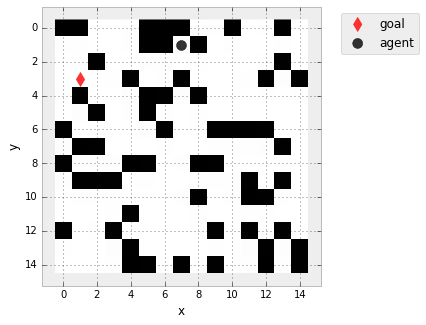

In [121]:
%matplotlib inline
Env = MazeEnv(15,15, threshold=1.2)
Env.reset()
Env.render()

In [122]:
%%time
q = Parameters(Env)
Agt = Agent(Policy=Greedy(Env=Env, Q=q))
Opt = SARSA_optimizer(Agt, eta=1., gamma=0.2)
N_episode = 6000

""" ##### アニメーションする場合 最初に #
%matplotlib notebook 
from maze import get_fig_ax
fig, ax = get_fig_ax()
N_episode = 30
#"""

for episode in range(N_episode):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
        if Env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break
""" ##### アニメーションする場合 一個目の#抜く
        Env.render(fig=fig, ax=ax, values_table=q.values_table)
        
%matplotlib inline
#"""

CPU times: user 7.81 s, sys: 138 ms, total: 7.94 s
Wall time: 7.84 s


学習後のエージェントで迷路を解かせてみます：

<IPython.core.display.Javascript object>


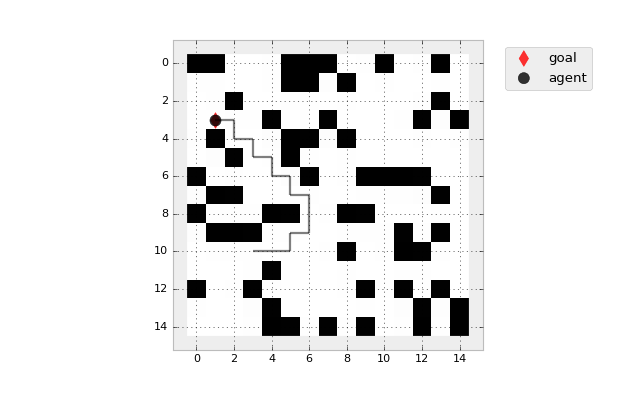

solved!


In [131]:
Env.reset()
%matplotlib notebook 
Env.play_interactive(Agt)
%matplotlib inline

`Env.render()`に推定された行動価値関数を図示するオプション
* `Env.render(values_table)`

を用意してみました。
濃い色ほど$Q(s,a)$の値が大きいことを意味します。

/Users/akinoritanaka/Documents/repository/HPC-Phys_tutorial_and_hands-on/maze.py:132: RuntimeWarning: invalid value encountered in true_divide
  vt = np.transpose(values_table*self.tile.reshape(lx, ly, 1)/vmaxs, (1,0,2))


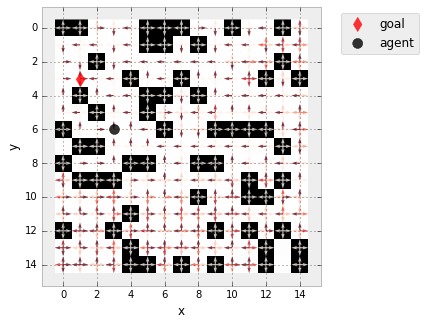

In [132]:
Env.reset()
Env.render(values_table=q.values_table)

## 2-3. Q学習
迷路は簡単な問題だったので、greedy方策+SARSAで十分高速に解けましたが、より難しく、探索が沢山必要な問題ではε-greedy方策を使ったほうが良い場合もあるでしょう。

試してみた方はわかると思いますが、迷路サイズが大きくなると、ε-greedy方策+SARSAはやや遅いです。greedy方策+SARSAが早かったのは、

$$
\left. \begin{array}{l:ll:ll:ll}
\dots
&
s
&
{\to}
a
{\to} 
&
s_\text{next}
&
\overset{\pi_{greedy}(\cdot|s_\text{next})}{\to}
a_\text{next}
{\to} 
&
 \cdots
\\
&&&
\downarrow
\\
&
-
&&
r_\text{next}
\end{array} \right.
$$

で $a_\text{next} = \text{argmax}_{a'}q(s_\text{next}, a')$ が最適であり、ゴールに設定された報酬がスタートに伝搬しやすくなっているためと考えられます。

そこで
$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta \underbrace{ \Big(q(s,a) - \big[ r_\text{next} + \gamma q(s_\text{next}, a_\text{next}) \big] \Big)}_\text{TD error}
\end{array} \right.
$$

ではなく、

$$
\left. \begin{array}{ll}
q(s,a) &\leftarrow 
q(s,a) - \eta  \Big(q(s,a) - \big[ r_\text{next} + \gamma \max_{a'} q(s_\text{next}, a') \big] \Big)
\end{array} \right.
$$

とすることが考えられます。これを**Q学習(Q-learning)**といいます：

In [56]:
class Qlearning_optimizer(Optimizer):
    def __init__(self, Agt, eta, gamma):
        self.Agent = Agt
        self.Q = Agt.Policy.Q
        self.eta = eta
        self.gamma = gamma

    def update(self, s, a, r_next, s_next):
        # a_nextのサンプル無し
        error = self.Q.get_values(s)[a] - (r_next + 
                                           self.gamma*np.max(self.Q.get_values(s_next)))
                                                       # ↑ ここが変わった
        self.Q.get_values(s)[a] -= self.eta*error

一応デモンストレーション：

In [70]:
%%time
q = Parameters(Env)
Agt = Agent(Policy=EpsilonGreedy(Env=Env, Q=q))
Opt = Qlearning_optimizer(Agt, eta=1., gamma=0.2)
N_episode = 6000

""" ##### アニメーションする場合 最初に #
%matplotlib notebook 
from maze import get_fig_ax
fig, ax = get_fig_ax()
N_episode = 30
#"""

for episode in range(N_episode):
    Env.reset()
    while not Env.is_solved():
        s = Env.get_state()
        a = Agt.play()
        s_next, r_next, _, _ = Env.step(a)
        Opt.update(s, a, r_next, s_next)
        if Env.t > 100: # たまにゴールできない位置に置かれてしまうので
            break
""" ##### アニメーションする場合 一個目の#抜く
        Env.render(fig=fig, ax=ax, values_table=q.values_table)
        
%matplotlib inline
#"""

CPU times: user 8.95 s, sys: 167 ms, total: 9.12 s
Wall time: 9.09 s


/Users/akinoritanaka/Documents/repository/HPC-Phys_tutorial_and_hands-on/maze.py:132: RuntimeWarning: invalid value encountered in true_divide
  vt = np.transpose(values_table*self.tile.reshape(lx, ly, 1)/vmaxs, (1,0,2))


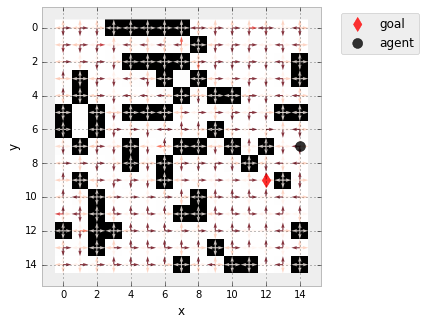

In [71]:
Env.reset()
Env.render(values_table=q.values_table)

## ● Deep Q-Network (DQN)
**Q学習**と深層学習を組み合わせたのが**深層Q学習ネットワーク(Deep Q-Network, DQN)**です。
今回、実装はしませんが説明だけしておきます。論文はDeepMindによる
https://arxiv.org/abs/1312.5602
で、アルファ碁以前の深層強化学習論文だとおもいます。

これまでの
```
q = Parameters(Env)
```
では$Q(s, a)$の「テーブル」を用意して、テーブルの値をs, a毎に更新していたのでしたが、s, aの空間が巨大になると、必然的にテーブルも巨大になり、学習がはかどらなさそうです。

そこで、s を入力に取り、aの個数分の出力を持った深層ニューラルネット（**Deep Q-Network**）$f_Q$を導入し

$$
f_Q(s) =
\begin{pmatrix}
y_0 
\\
y_1 
\\
\vdots
\\
y_{\# a}
\end{pmatrix}
\approx
\begin{pmatrix}
Q(s, a=0)
\\
Q(s, a=1)
\\
\vdots
\\
Q(s, a=\# a)
\end{pmatrix}
$$

だと解釈します。`q = Parameters(Env)`のような (s, a) テーブルの代わりに、s$\to$a の関数を考えるのです。

ニューラルネットの出力値が$Q$の値になるようにするので、そのまま**Q学習**の考え方が使えます。Q学習は

$$
l(q) = \frac{1}{2} 
\Big(q(s,a) - \big[ r_\text{next} + \gamma \max_{a'}q(s_\text{next}, a') \big] \Big)^2
$$

の誤差関数を減少させる学習だったので、$q(s,a) = [f_Q(s)]_a$として、ニューラルネットの誤差関数をこれに設定：

$$
l(f_Q) = \frac{1}{2} 
\Big([f_Q(s)]_a - \big[ r_\text{next} + \gamma \max_{a'}[f_Q(s_\text{next})]_{a'} \big] \Big)^2
$$

し、勾配更新

$$
f_Q \leftarrow f_Q - \eta \nabla_{f_Q} l(f_Q)
$$

すればよいのです。実際にはこれだけでなく、いくつかの工夫を更に組み合わせますが、アイデアとしては単純なものです。論文では
* $s$:ゲームの画面のピクセル値
* $a$:コントローラーのボタン

という人間と対等な環境でAtari社のクラシックゲーム（ブロック崩しなど）を解かせています。例えば
https://www.youtube.com/watch?v=TmPfTpjtdgg
が公式？の動画ですが、0:50あたりまで見ると、ブロック崩しでブロックの裏側にボールを打ち出すテクニックが発見されたりして面白いです。
また
https://www.youtube.com/watch?v=MKtNv1UOaZA
などで、学習中の動画が見れます。